In [4]:
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from pdf2image import convert_from_path

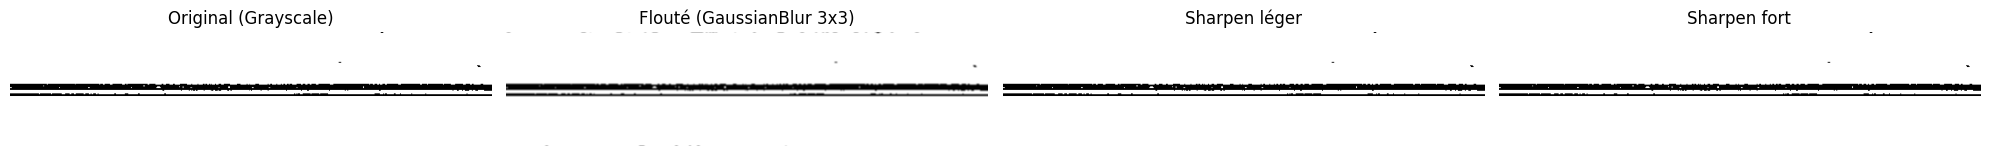

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pdf2image import convert_from_path
from PIL import Image
import pytesseract

# --- 1️⃣ Charger la première page du PDF ---
pdf_path = "CH-121251-A_full.pdf"
page = convert_from_path(pdf_path, dpi=300, first_page=1, last_page=1)[0]
gray = np.array(page.convert("L"))

# --- 2️⃣ Fonctions utiles ---
def unsharp_mask(gray, sigma=1.0, strength=1.5):
    blur = cv2.GaussianBlur(gray, (0, 0), sigma)
    return cv2.addWeighted(gray, 1 + strength, blur, -strength, 0)

def show_images(images, titles, cmap="gray"):
    n = len(images)
    plt.figure(figsize=(5*n, 6))
    for i, (img, title) in enumerate(zip(images, titles)):
        plt.subplot(1, n, i + 1)
        plt.imshow(img, cmap=cmap)
        plt.title(title)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# --- 3️⃣ Versions de traitement ---
blurred = cv2.GaussianBlur(gray, (3, 3), 0)
sharp_soft = unsharp_mask(gray, sigma=1.0, strength=1.0)
sharp_strong = unsharp_mask(gray, sigma=1.0, strength=2.5)

# --- 4️⃣ OCR sur chaque version ---
ocr_orig = pytesseract.image_to_string(gray, lang="deu")
ocr_blur = pytesseract.image_to_string(blurred, lang="deu")
ocr_sharp_soft = pytesseract.image_to_string(sharp_soft, lang="deu")
ocr_sharp_strong = pytesseract.image_to_string(sharp_strong, lang="deu")

# --- 5️⃣ Affichage comparatif ---
show_images(
    [gray, blurred, sharp_soft, sharp_strong],
    ["Original", "GaussianBlur (3x3)", "Sharpen léger", "Sharpen fort"]
)

# --- 6️⃣ Afficher les textes OCRisés ---
print("🧾 OCR résultats comparatifs:\n")
print("— Original —")
print(ocr_orig[:500])
print("\n— Flouté (GaussianBlur 3x3) —")
print(ocr_blur[:500])
print("\n— Sharpen léger —")
print(ocr_sharp_soft[:500])
print("\n— Sharpen fort —")
print(ocr_sharp_strong[:500])
